In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import multiprocessing
import jax
from cohlib.utils import add0
import jax.random as jr

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={multiprocessing.cpu_count()}"
# os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={10}"
jax.config.update('jax_platform_name', 'cpu')
platform = jax.lib.xla_bridge.get_backend().platform.casefold()
print("Platform: ", platform)
print(len(jax.devices()))

Platform:  cpu
28


In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.confs.utils import omega

In [16]:
# L = 10 
# ov2 = -1.0
K = 3
L = 10
seed = 1
mu = -1.0
init = 'empirical'
res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_eigvals-fit_eigvecs-fit/newton-10_em-20/res.pkl'
# res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_eigvals-oracle_eigvecs-fit/newton-10_em-20/res.pkl'
obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

# latent_load = pickle_open(latent_path)
# obs_load = pickle_open(obs_path)
res_load = pickle_open(res_path)
obs_load = pickle_open(obs_path)
latent_load = pickle_open(latent_path)


In [17]:
import cohlib.confs.utils as conf
from cohlib.general_model import GeneralToyModel
obs = obs_load['obs']
zs_nz = latent_load['zs_nz']
cfg = omega(res_load['cfg'])
lcfg = cfg.latent
mcfg = cfg.model
ocfg = cfg.obs

N = lcfg.num_freqs
freqs = jnp.arange(N)
nz_model = jnp.array([lcfg.target_freq_ind])

init_params = {'rank': mcfg.model_rank, 
            'nz_model': nz_model,
            'scale_init': mcfg.scale_init,
            'K': K,
            'lcfg': lcfg,
            'zs_nz': zs_nz,
            'ocfg': ocfg,
            'obs': obs}

In [18]:
from cohlib.confs.utils import create_lrccn_basic_rank1
lrccn = create_lrccn_basic_rank1(lcfg)

In [19]:
lrccn.eigvals

Array([[3000000.]], dtype=float32)

In [20]:
rank = 1
J = 1
eigvals_init = jnp.zeros((J,rank))
eigvecs_init = jnp.zeros((J,K,rank), dtype=complex)
gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
for j in range(J):
    freqind = nz_model[j]
    eigvals_oracle_j, eigvecs_oracle_j = jnp.linalg.eigh(gamma_oracle[freqind,:,:])
    eigvecs_init = eigvecs_init.at[j,:,:].set(eigvecs_oracle_j[:,-rank:][:,::-1])
    eigvals_init = eigvals_init.at[j,:].set(eigvals_oracle_j[-rank:][::-1])

In [21]:
1e6

1000000.0

In [22]:
res_load['lrccn_init'].eigvals

Array([[1520217.2]], dtype=float32)

In [23]:
def q_func_lowrank_latent(lrccn, sigmas):
    gamma_lrinv = lrccn.get_gamma_pinv()
    gamma_det = jnp.prod(lrccn.eigvals, axis=1)

    a = jnp.trace(gamma_lrinv @ sigmas, axis1=1, axis2=2).sum()
    b = L*(lrccn.rank*jnp.log(jnp.pi) + jnp.log(gamma_det)).sum()

    return -(a+b)



In [24]:
r = 0
rk = jr.key(7)
L = obs.shape[-1]

lrccn_init = res_load['track']['lrccn'][r]
# calculate sample-values for P(O|z^m)
zs = lrccn_init.sample(rk, L)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

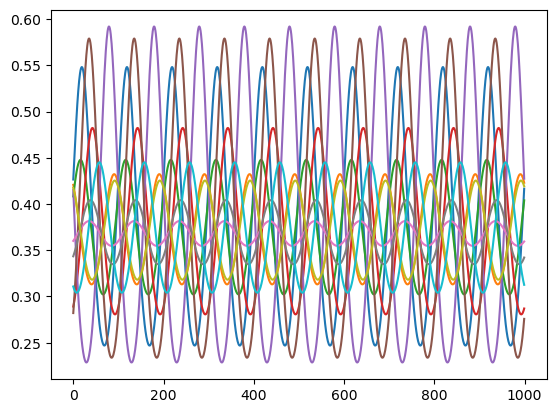

In [25]:
lams = jnp.exp(xs + mu)
k = 0
l = 1
for l in range(L):
    plt.plot(lams[:,k,l])

In [26]:
# something is likely wrong here....
def q_func_lowrank_obs(obs, lrccn, rk, M, mu, delta=1e-3):
    # sample zs for monte carlo
    rksplit = jr.split(rk, M)
    obs_lls = jnp.zeros(M)
    L = obs.shape[-1]

    # calculate sample-values for P(O|z^m)
    for m in range(M):
        zs = lrccn.sample(rksplit[m], L)
        zs_0dc = jnp.apply_along_axis(add0, 0, zs)
        xs = jnp.fft.irfft(zs_0dc, axis=0)

        log_lams = xs + mu
        lams = jnp.exp(log_lams)

        obs_ll_calc = obs*(jnp.log(delta) + log_lams) - lams*delta
        obs_lls = obs_lls.at[m].set(obs_ll_calc.sum()) 
    return obs_lls.mean()


In [31]:
eigvals = res_load['track']['lrccn'][0].eigvals
ev1 = res_load['track']['lrccn'][0].eigvecs

In [32]:
from cohlib.utils import rotate_eigvecs
ev2 = rotate_eigvecs(res_load['track']['lrccn'][0].eigvecs)

(1, 1)

In [19]:
from cohlib.utils import add0
import jax.random as jr
M = 25
mcrk = jr.key(7)
num_iters = 5
q_vals = jnp.zeros(num_iters)
q_vals_latent = jnp.zeros(num_iters)
q_vals_obs = jnp.zeros(num_iters)
alphas_emiters = []
Upss_emiters = []

for r in range(num_iters):
    print(f"Calculating Q-val at update for iteration {r}.")
    # instantiate model at rth iteration
    model = GeneralToyModel()
    lrccn_init = res_load['track']['ccn'][r]
    print("Starting eigvec:")
    print(f"{lrccn_init.eigvecs}")
    obs_params, obs_type = conf.get_obs_params(ocfg)

    model.initialize_latent(lrccn_init)
    model.initialize_observations(obs_params, obs_type)

    fixed_params = conf.get_fixed_params(mcfg.eigvals_flag, mcfg.eigvecs_flag, init_params)

    # run one EM iteration
    fit_params = {'num_em_iters': 1, 
                'num_newton_iters': mcfg.num_newton_iters,
                'm_step_option': mcfg.m_step_option,
                'fixed_params': fixed_params}
    model.fit_em(obs, fit_params)

    # calculate Sigmas 
    alphas = model.alphas
    alphas_emiters.append(alphas)
    Upss = model.Upss
    Upss_emiters.append(Upss)
    alphas_outer = jnp.einsum('nkl,nil->nkil', alphas, alphas.conj())

    Sigma_ests = (alphas_outer + 2*Upss)

    # calculate q-val at update
    q_eval_latent = q_func_lowrank_latent(model.lrccn, Sigma_ests).real
    q_eval_obs = q_func_lowrank_obs(obs, lrccn_init, mcrk, M, mu)
    q_vals = q_vals.at[r].set(q_eval_latent + q_eval_obs)
    q_vals_latent = q_vals_latent.at[r].set(q_eval_latent)
    q_vals_obs = q_vals_obs.at[r].set(q_eval_obs)

Calculating Q-val at update for iteration 0.
Starting eigvec:
[[[0.33333334+0.j]
  [0.33333334+0.j]
  [0.33333334+0.j]]]
EM Iter 1
Running batch 0: trials 1 - 25
eigvec update:
[[[-0.59999996+0.j        ]
  [-0.26      -0.45j      ]
  [-0.51      +0.32999998j]]]
eigval update:
[[2910276.]]
Calculating Q-val at update for iteration 1.
Starting eigvec:
[[[-0.5966642 +0.j        ]
  [-0.25986576-0.45477855j]
  [-0.5095144 +0.3317127j ]]]
EM Iter 1
Running batch 0: trials 1 - 25
eigvec update:
[[[-0.55+0.j        ]
  [-0.26-0.53j      ]
  [-0.51+0.29999998j]]]
eigval update:
[[2910276.]]
Calculating Q-val at update for iteration 2.
Starting eigvec:
[[[-0.5503159 +0.j        ]
  [-0.25920802-0.5250172j ]
  [-0.5131574 +0.30164567j]]]
EM Iter 1
Running batch 0: trials 1 - 25
eigvec update:
[[[-0.55+0.j        ]
  [-0.26-0.52j      ]
  [-0.52+0.29999998j]]]
eigval update:
[[2910276.]]
Calculating Q-val at update for iteration 3.
Starting eigvec:
[[[-0.5484207 +0.j        ]
  [-0.25694853-0.51

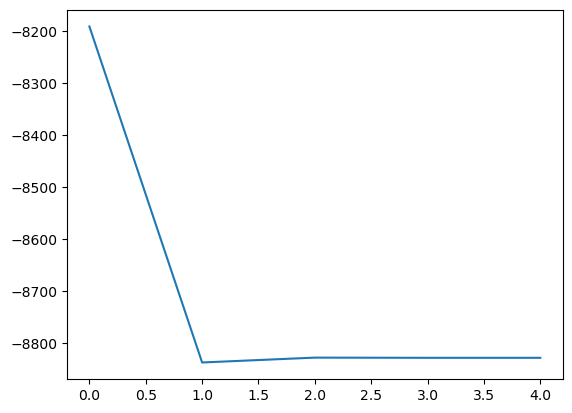

In [15]:
plt.plot(q_vals)

In [18]:
q_vals_obs

Array([-7784.2803, -8432.6875, -8423.273 , -8423.743 , -8423.639 ],      dtype=float32)

In [19]:
q_vals_latent

Array([-406.8244 , -404.18802, -404.25967, -404.16748, -404.25516],      dtype=float32)

In [ ]:
# hmmm this seems very suspect.... 

In [42]:
alphas_stack = jnp.stack([alphas_emiters[r] for r in range(num_iters)], axis=-1)

In [43]:
alphas_stack.shape

(1, 3, 25, 5)

Let's compare true `zs` and `xs` to inferred across em iterations

In [44]:
freqs = latent_load['freqs']
nz = latent_load['nz']
zs_true = jnp.zeros((freqs.size,K,L), dtype=complex)
zs_true = zs_true.at[nz,:,:].set(zs_nz)

zs_true_0dc = jnp.apply_along_axis(add0, 0, zs_true)
xs_true = jnp.fft.irfft(zs_true_0dc, axis=0)

In [45]:
zs_em = jnp.zeros((freqs.size,K,L,num_iters), dtype=complex)
zs_em = zs_em.at[nz,:,:,:].set(alphas_stack)

zs_em_0dc = jnp.apply_along_axis(add0, 0, zs_em)
xs_em = jnp.fft.irfft(zs_em_0dc, axis=0)

In [46]:
xs_em.shape

(1000, 3, 25, 5)

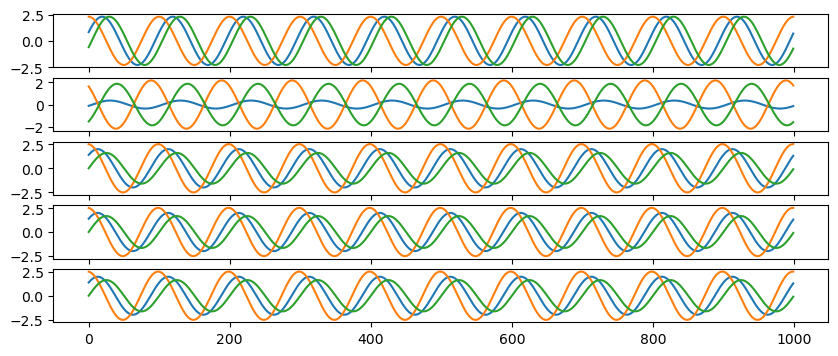

In [54]:
l = 9
fig, ax = plt.subplots(5,1, figsize=(10,4))
for k in range(K):
    ax[0].plot(xs_true[:,k,l])
    for r in range(4):
        ax[r+1].plot(xs_em[:,k,l,r])

In [18]:
Sigma_ests.shape


(1, 3, 3, 50)

In [19]:
gamma_lrinv = lrccn.get_gamma_pinv()
gamma_lrinv.shape

(1, 3, 3)

In [25]:
jnp.trace(gamma_lrinv @ Sigma_ests, axis1=1, axis2=2).sum()

Array(53.076782-0.09939098j, dtype=complex64)

In [26]:
jnp.trace(gamma_lrinv @ Sigma_ests, axis1=1, axis2=2)

Array([53.75+0.0324707j], dtype=complex64)

In [31]:
(gamma_lrinv @ Sigma_ests).sum(-1)

Array([[[ 2022.751 -1263.9888j,  2022.751 -1263.9888j,
          2022.751 -1263.9888j],
        [ -419.8695 -295.1026j,  -419.8695 -295.1026j,
          -419.8695 -295.1026j],
        [-1549.8047+1558.9921j, -1549.8047+1558.9921j,
         -1549.8047+1558.9921j]]], dtype=complex64)

In [53]:
arr = jnp.array([[1,2,3],[2,3,4]])
test = jnp.prod(arr, axis=1)
test.shape

(2,)

In [51]:
jnp.prod(lrccn.eigvals, axis=1)

Array([3.], dtype=float32)

In [57]:
sigmas = Sigma_ests
gamma_lrinv = lrccn.get_gamma_pinv()
gamma_det = jnp.prod(lrccn.eigvals, axis=1)

a = jnp.trace(gamma_lrinv @ sigmas, axis1=1, axis2=2)
b = L*(lrccn.rank*jnp.log(jnp.pi) + jnp.log(gamma_det))

Array([112.16711], dtype=float32)

In [92]:
from cohlib.utils import add0
import jax.random as jr
lrccn = res_load['track']['ccn'][3]
rk = jr.key(7)

data = obs
delta = 1e-3
M = 5
# zs = lrccn.sample_nz(rk, M)
rksplit = jr.split(rk, M)
obs_lls = jnp.zeros(M)
for m in range(M):
    zs = lrccn.sample(rksplit[m], L)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    log_lams = xs + mu
    lams = jnp.exp(log_lams)

    obs_ll_calc = data*(jnp.log(delta) + log_lams) - lams*delta
    obs_lls = obs_lls.at[m].set(obs_ll_calc.sum()) 

In [94]:
obs_lls.mean()

Array(-3211.3528, dtype=float32)

Array(-3069.7825, dtype=float32)

In [84]:
lrccn.eigvecs

Array([[[ 0.68994766+6.031714e-08j],
        [-0.24277136-3.568223e-01j],
        [-0.14391638+5.630276e-01j]]], dtype=complex64)

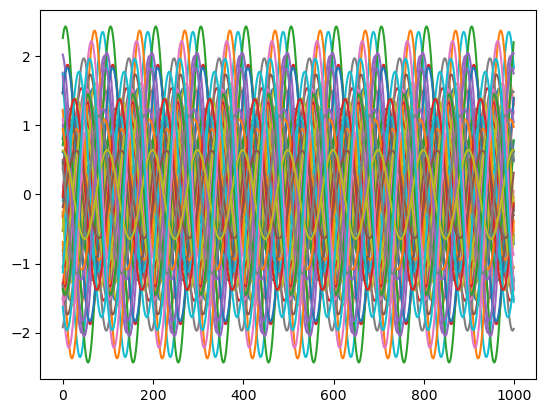

In [87]:
for l in range(L):
    plt.plot(xs[:,1,l])

In [71]:
log_lams = xs + mu
lams = jnp.exp(log_lams)

In [ ]:
def Q_func(Gamma_r, Gamma_r_inv, Sigmas_r):
    L = Sigmas_r.shape[0]
    K = Gamma_r_inv.shape[1]
    sum_A = L*(K*np.log(np.pi) + np.log(np.abs(np.linalg.det(Gamma_r)))).sum()
    sum_B = np.trace(Gamma_r_inv @ Sigmas_r, axis1=2, axis2=3).sum()
    Q = -(sum_A + sum_B)

    return sum_A, sum_B, Q.real